# Uncertainty Estimation Using Deep Neural Networks (DNNs)

This document provides an overview and detailed methods on leveraging Deep Neural Networks (DNNs) for uncertainty estimation in various applications, such as geophysical inversion, prediction tasks, and other domains where uncertainty quantification is essential.

## Table of Contents

1. [Introduction](#introduction)
2. [Methods of Uncertainty Estimation](#methods-of-uncertainty-estimation)
   - [Bayesian Neural Networks (BNNs)](#bayesian-neural-networks-bnns)
   - [Monte Carlo Dropout](#monte-carlo-dropout)
   - [Deep Ensembles](#deep-ensembles)
   - [Posterior Distribution Approximation](#posterior-distribution-approximation)
   - [Laplace Approximation](#laplace-approximation)
3. [Applications](#applications)
   - [Geophysical Inversion](#geophysical-inversion)
   - [Prediction Confidence](#prediction-confidence)
   - [Handling Noisy and Limited Data](#handling-noisy-and-limited-data)
4. [Conclusion](#conclusion)
5. [References](#references)

## Introduction

Uncertainty estimation is a crucial aspect when deploying machine learning models, especially in fields like geophysical inversion or predictive modeling, where understanding the confidence and reliability of predictions is paramount. Traditional deterministic models provide single-point predictions, often overlooking the uncertainty associated with model parameters or data. 

By using DNNs for uncertainty estimation, we can quantify the variability and confidence in predictions, helping to better interpret model outputs, guide decisions, and reduce risks associated with uncertainty.

## Methods of Uncertainty Estimation

This document explores various methods for quantifying uncertainty using DNNs:

### Bayesian Neural Networks (BNNs)
BNNs model uncertainty by treating network weights as probability distributions rather than fixed values. This allows for capturing both epistemic (model-related) and aleatoric (data-related) uncertainty. BNNs can be implemented using techniques like Variational Inference (VI) or Markov Chain Monte Carlo (MCMC).

### Monte Carlo Dropout
Monte Carlo Dropout leverages dropout, a regularization technique, as an approximation to Bayesian inference. By enabling dropout during both training and inference, multiple stochastic passes through the model help estimate uncertainty from the distribution of predictions.

### Deep Ensembles
Deep Ensembles involve training multiple independent neural networks and combining their predictions to estimate uncertainty. The variation among models provides insights into prediction confidence and robustness.

### Posterior Distribution Approximation
Variational Autoencoders (VAEs) and other techniques can be used to approximate posterior distributions, helping to quantify uncertainty by learning latent variable representations that capture uncertainty in predictions.

### Laplace Approximation
Laplace Approximation approximates the posterior distribution around the mode of the neural network’s parameters, providing a way to quantify uncertainty by modeling the loss landscape with a Gaussian distribution.

## Applications

### Geophysical Inversion
In the field of geophysics, uncertainty estimation helps quantify the reliability of subsurface models derived from seismic data. By incorporating DNNs, these inversion models can estimate uncertainty, offering insights into the confidence of the predicted subsurface structure.

### Prediction Confidence
DNN-based models can be used to assess prediction confidence in various domains. Whether in finance, healthcare, or engineering, uncertainty estimation helps ensure that predictions are accompanied by a measure of their reliability.

### Handling Noisy and Limited Data
In scenarios with limited or noisy data, uncertainty estimation allows models to account for the increased uncertainty in predictions. This enables researchers and practitioners to be more cautious when making decisions based on model outputs.

## Conclusion

This document outlines how DNNs can be employed to estimate uncertainty, enhancing the interpretability and robustness of model predictions. Uncertainty estimation is vital in high-stakes applications, and incorporating these techniques ensures that decision-makers have more informed insights when utilizing machine learning models.

## References

- Blundell, C., et al. "Weight Uncertainty in Neural Networks." *International Conference on Machine Learning* (2015).
- Gal, Y., Ghahramani, Z. "Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning." *International Conference on Machine Learning* (2016).
- Lakshminarayanan, B., Pritzel, A., Blundell, C. "Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles." *NeurIPS* (2017).

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib
from scipy import integrate
import sys
import os
sys.path.append("../../../../")
from ADFWI.propagator  import *
from ADFWI.model       import *
from ADFWI.view        import *
from ADFWI.utils       import *
from ADFWI.survey      import *
from ADFWI.fwi         import *
from ADFWI.dip import *
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

: 

In [3]:
def MSE(true_v,inv_v):
    nz,nx = true_v.shape
    return np.sum((true_v-inv_v)**2)/(nz*nx)

def MAPE(true_v,inv_v):
    if len(true_v.shape) != len(inv_v.shape):
        nz,nx = true_v.shape
        true_v = true_v[np.newaxis,:,:]
        res = 100/(nx*nz) * np.sum(np.abs(inv_v-true_v)/true_v,axis=(1,2))
    else:
        nz,nx = true_v.shape[-2:]
        res = 100/(nx*nz) * np.sum(np.abs(inv_v-true_v)/true_v)
    return res

from skimage.metrics import structural_similarity as ssim
def SSIM(true_v,inv_v,win_size=3):
    if len(true_v.shape) != len(inv_v.shape):
        ssim_res = []
        for i in range(inv_v.shape[0]):
            vmax = np.max([true_v.max(),inv_v[i].max()])
            vmin = np.min([true_v.min(),inv_v[i].min()])
            temp_ssim =  ssim(true_v,inv_v[i],data_range=vmax-vmin,win_size=win_size)
            ssim_res.append(temp_ssim)
        return ssim_res
    else:
        vmax = np.max([true_v.max(),inv_v.max()])
        vmin = np.min([true_v.min(),inv_v.min()])
        return ssim(true_v,inv_v,data_range=vmax-vmin,win_size=win_size)
    
def SNR(true_v,inv_v):
    if len(true_v.shape) != len(inv_v.shape):
        snr_res = []
        for i in range(inv_v.shape[0]):
            true_norm  = np.sum(true_v**2)
            diff_norm = np.sum((true_v-inv_v[i])**2)
            temp_snr = 10*np.log10(true_norm/diff_norm)
            snr_res.append(temp_snr)
        return snr_res
    else:
        true_norm  = np.sum(true_v**2)
        diff_norm = np.sum((true_v-inv_v)**2)
        temp_snr = 10*np.log10(true_norm/diff_norm)
        return temp_snr

In [4]:
device = "cuda:0"
dtype = torch.float32
ox,oz = 0,0
nz,nx = 88,200
dx,dz = 40, 40
nt,dt = 1600, 0.003
nabc  = 30
f0    = 5
free_surface = True

In [5]:
#------------------------------------------------------
#                   Velocity Model
#------------------------------------------------------
marmousi_model = load_marmousi_model(in_dir="./examples/datasets/marmousi2_source")
x = np.linspace(5000, 5000+dx*nx, nx)
z = np.linspace(0, dz*nz, nz)
# true and smooth model
true_model  = resample_marmousi_model(x, z, marmousi_model)
smooth_model= get_smooth_marmousi_model(true_model,gaussian_kernel=6)
vp_init     = smooth_model['vp'].T
rho_init    = np.power(vp_init, 0.25) * 310
vp_true     = true_model['vp'].T
rho_true    = np.power(vp_true, 0.25) * 310

In [7]:
# -----------------------------------
#     Define DIP model
# -----------------------------------
model_shape = [nz,nx]
DIP_model1 = DIP_CNN(model_shape,in_channels=[4,32],vmin=vp_true.min()/1000,vmax=vp_true.max()/1000,dropout_prob=0.1,device=device)
DIP_model2 = DIP_CNN(model_shape,in_channels=[4,32],vmin=vp_true.min()/1000,vmax=vp_true.max()/1000,dropout_prob=0.2,device=device)
DIP_model1.to(device)
DIP_model2.to(device)

# -----------------------------------
#     Trained DIP model
# -----------------------------------
DIP_model1.load_state_dict(torch.load("./examples/dip/01_Multi-CNN/data/inversion-2layer-4-32/DIP_model.pt"))
DIP_model2.load_state_dict(torch.load("./examples/dip/01_Multi-CNN/data/inversion-2layer-4-32/DIP_model.pt"))

<All keys matched successfully>

In [9]:
# -----------------------------------
#     MonteCarlo Sampling
# -----------------------------------
vp_montecarlo1 = []
vp_montecarlo2 = []

for i in range(1000):
    if i != 0:
        DIP_model1.train()
        DIP_model2.train()
    else:
        DIP_model1.eval()
        DIP_model2.eval()
    vp_nn1 = DIP_model1()
    vp_nn2 = DIP_model2()
    vp_montecarlo1.append(vp_nn1.cpu().detach().numpy())
    vp_montecarlo2.append(vp_nn2.cpu().detach().numpy())
vp_montecarlo1 = np.array(vp_montecarlo1)
vp_montecarlo2 = np.array(vp_montecarlo2)
vp_montecarlo1[:,:10,:] = vp_true[:10,:]
vp_montecarlo2[:,:10,:] = vp_true[:10,:]

## Figure

In [10]:
x = np.arange(nx)*dx/1000
z = np.arange(nz)*dz/1000
x_mesh,z_mesh = np.meshgrid(x,z)
src_z = np.array([1  for i in range(2,nx-1,5)])*dz/1000
src_x = np.array([i  for i in range(2,nx-1,5)])*dx/1000
rcv_z = np.array([1  for i in range(0,nx,1)])*dz/1000
rcv_x = np.array([j  for j in range(0,nx,1)])*dz/1000
vmin = vp_true.min();vmax = vp_true.max()

def plot_vel_single_for_all(fig,ax,v,title="",MSE="",vmin=1000,vmax=5000,cmap="rainbow"):
    plt.rc('font',family='Times New Roman')
    cmap = cmap
    # plm = ax.pcolormesh(x_mesh, z_mesh, v,cmap=cmap,vmin=vmin,vmax=vmax)
    # high resolution figures
    nz,nx = v.shape
    x = np.arange(nx*3)*dx/3/1000
    z = np.arange(nz*3)*dz/3/1000
    x_mesh_new,z_mesh_new = np.meshgrid(x,z)
    from scipy.interpolate import griddata
    v_new = griddata((x_mesh.flatten(), z_mesh.flatten()), v.flatten(), (x_mesh_new, z_mesh_new), method='cubic')
    
    plm = ax.pcolormesh(x_mesh_new, z_mesh_new, v_new,cmap=cmap,vmin=vmin,vmax=vmax,shading="nearest")
    ax.invert_yaxis()
    ax.tick_params(labelsize = 16)
    ax.set_title(title,fontsize=16)
    ax.text(5.3,0.35,MSE,fontsize=16,c="w")
    return plm

import matplotlib.transforms as mtransforms
def add_right_cax(ax, pad, width):
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

def plot_vel_singleline_for_all(ax,v_true,v_init,v_inv,x_distance,title,show_xlabel=True,show_ylabel=False,show_legend=False):
    ax.plot(v_true[:,int(x_distance//dx)]/1000,  z, c='k',   linewidth=2, linestyle="-" ,label="True")
    ax.plot(v_init[:,int(x_distance//dx)]/1000,  z, c='gray',linewidth=2, linestyle="-" ,label="Init")
    ax.plot(v_inv [:,int(x_distance//dx)]/1000,  z, c='r',   linewidth=2, linestyle="--",label="Inverted")
    ax.tick_params(labelsize = 16)
    if not show_xlabel:
        ax.set_xticks([])
        
    if not show_ylabel:
        ax.set_yticks([])
    else:
        ax.tick_params(labelsize = 12)
    ax.invert_yaxis()
    
    if show_legend:
        ax.legend(fontsize = 12)
    ax.set_title(title,fontsize=16)

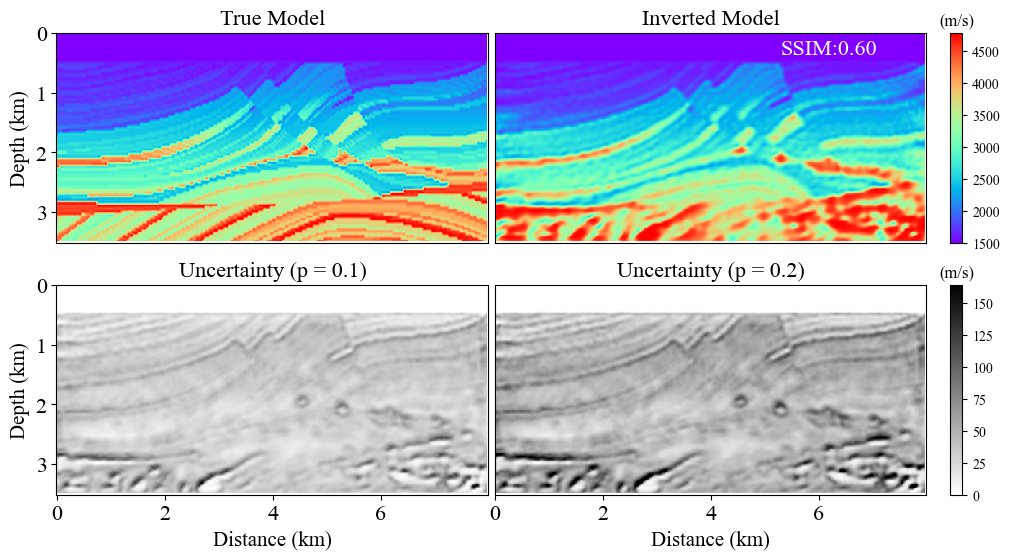

In [12]:
from matplotlib import gridspec
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 4)
ax11 = fig.add_subplot(gs[0, :2])
ax12 = fig.add_subplot(gs[0, 2:])
ax21 = fig.add_subplot(gs[1, :2])
ax22 = fig.add_subplot(gs[1, 2:])

true_v = vp_true
vp_uncertainty1 = np.sum(np.abs(vp_montecarlo1 - np.mean(vp_montecarlo1,axis=0)),axis=0)/vp_montecarlo1.shape[0]
vp_uncertainty2 = np.sum(np.abs(vp_montecarlo2 - np.mean(vp_montecarlo2,axis=0)),axis=0)/vp_montecarlo2.shape[0]

plot_vel_single_for_all(fig,ax11,true_v                  ,title=r"True Model"        ,  vmin = vmin,vmax=vmax,cmap='rainbow')
plm1 = plot_vel_single_for_all(fig,ax12,vp_montecarlo1[0],title=r"Inverted Model"    ,  MSE="SSIM:{:.2f}".format(SSIM(true_v[12:,:],vp_montecarlo1[0][12:,:])),vmin = vmin,vmax=vmax,cmap='rainbow')
plot_vel_single_for_all(fig,ax21,vp_uncertainty1         ,title=r"Uncertainty (p = 0.1)" ,  MSE="SSIM:{:.2f}".format(SSIM(true_v[12:,:],vp_uncertainty1[12:,:])),vmin = vp_uncertainty1.min(),vmax=vp_uncertainty1.max(),cmap='gray_r')
plm2 = plot_vel_single_for_all(fig,ax22,vp_uncertainty2  ,title=r"Uncertainty (p = 0.2)" ,  MSE="SSIM:{:.2f}".format(SSIM(true_v[12:,:],vp_uncertainty2[12:,:])),vmin = vp_uncertainty1.min(),vmax=vp_uncertainty1.max(),cmap='gray_r')


ax11.set_xticks([])
ax12.set_xticks([])
ax21.set_xlabel("Distance (km)", fontsize=15)
ax22.set_xlabel("Distance (km)", fontsize=15)
ax11.set_ylabel("Depth (km)",fontsize=15)
ax21.set_ylabel("Depth (km)",fontsize=15)
ax22.set_yticks([])
ax12.set_yticks([])

# Adjust the position of the subplots to make room for the colorbar
plt.subplots_adjust(hspace=0.2, wspace=0.03, right=0.85)

# colorbar
cax1 = add_right_cax(ax12, pad=0.02,width=0.01)
cbar1 = fig.colorbar(plm1, cax=cax1)
cbar1.ax.set_title('(m/s)')

cax2 = add_right_cax(ax22, pad=0.02,width=0.01)
cbar2 = fig.colorbar(plm2, cax=cax2)
cbar2.ax.set_title('(m/s)')

plt.savefig("examples/dip/01_Multi-CNN/data/inversion-2layer-4-32/Uncertainty_evaluate.png",bbox_inches='tight',dpi=300)
plt.show()